- remove age_first_funding_year from features

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mlxtend.plotting import scatterplotmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import shap
%matplotlib inline  

In [2]:
%run "../../plots.py"
%run "../../helper.py"

In [3]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('../../startup_data.csv')
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,1/1/2007,NaN,4/1/2009,1/1/2010,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,1/1/2000,NaN,2/14/2005,12/28/2009,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,3/18/2009,NaN,3/30/2010,3/30/2010,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,1/1/2002,NaN,2/17/2005,4/25/2007,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,8/1/2010,10/1/2012,8/1/2010,4/1/2012,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [4]:
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

Dataset contains 923 rows and 49 columns.


### Target variable

In [5]:
if (df['status'].dtype == object):
    df['status'] = df.status.map({'acquired': 1, 'closed': 0})

### Data splitting

In [6]:
features = ['age_last_funding_year', 'relationships', 'funding_rounds', 
            'funding_total_usd', 'milestones', 'has_VC', 'has_angel', 'has_roundA', 
            'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants', 'is_top500']

X = df[features]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=1)

In [7]:
model = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = { 
    'n_estimators': [200, 225, 250],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
}

### Nested cross-validation

In [8]:
outer_n_splits = 10
inner_n_splits = 3

gs = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  scoring='precision',
                  cv=inner_n_splits,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='precision', cv=outer_n_splits)

print(f'Nested CV precision: {np.mean(scores):.4f} +/-{np.std(scores):.4f}')

Nested CV precision: 0.7893 +/-0.0255


### Hyperparameter tuning

In [9]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='precision', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
best_model = gs.best_estimator_

print(gs.best_params_)

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 250}


### Feature importances

In [10]:
print_feature_importances(tree_classifier=best_model, X_columns=list(X_train.columns))

 1) relationships                  0.211174
 2) funding_total_usd              0.189084
 3) age_last_funding_year          0.177463
 4) avg_participants               0.105953
 5) milestones                     0.099494
 6) funding_rounds                 0.065877
 7) is_top500                      0.043840
 8) has_VC                         0.023154
 9) has_roundB                     0.021533
10) has_roundA                     0.020862
11) has_angel                      0.015498
12) has_roundC                     0.015030
13) has_roundD                     0.011038


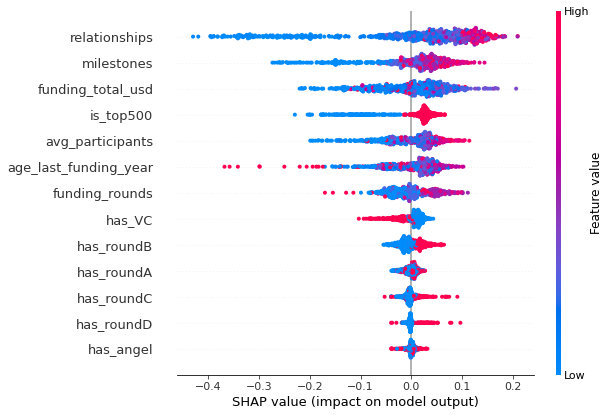

In [11]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train)

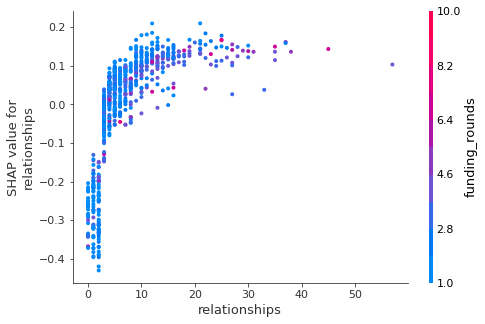

In [12]:
shap.dependence_plot('relationships', shap_values[1], X_train)

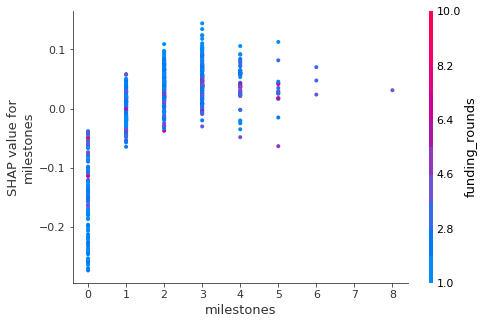

In [13]:
shap.dependence_plot('milestones', shap_values[1], X_train)

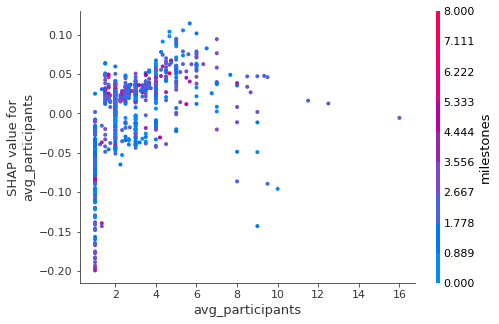

In [14]:
shap.dependence_plot('avg_participants', shap_values[1], X_train)

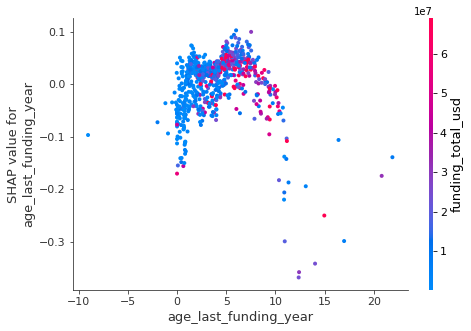

In [15]:
shap.dependence_plot('age_last_funding_year', shap_values[1], X_train)

### Model evaluation

In [16]:
y_pred = best_model.predict(X_train)

evaluate_classifier(y_train, y_pred)

Accuracy: 1.0000
Recall: 1.0000
Precision: 1.0000
F1: 1.0000


In [17]:
y_pred = best_model.predict(X_test)

evaluate_classifier(y_test, y_pred)

Accuracy: 0.7622
Recall: 0.8917
Precision: 0.7754
F1: 0.8295


In [18]:
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
confusion_matrix

array([[ 34,  31],
       [ 13, 107]], dtype=int64)

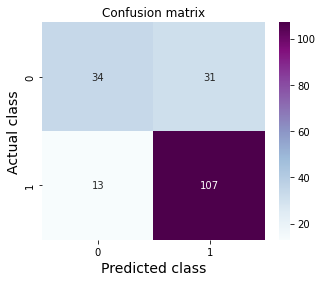

In [19]:
plot_confusion_matrix(confusion_matrix=confusion_matrix, figsize=(5, 4))

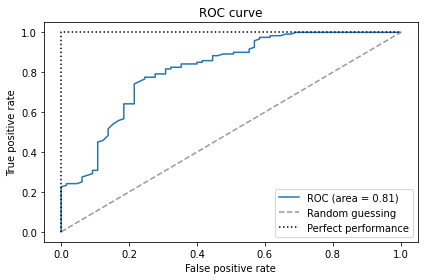

In [20]:
plot_roc_curve(classifier=best_model, X_test=X_test, y_test=y_test)

### Comparing false positives with true positives

In [21]:
y_test_arr = y_test.to_numpy()
false_positives = (y_test_arr != y_pred) & (y_test_arr == 0)
df_false_positives = X_test[false_positives]
print(f'False positives count: {len(df_false_positives)}')
df_false_positives

False positives count: 31


,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
439,7.1973,6,3,25500100,3,1,0,0,1,0,0,2.50,1
345,1.3781,7,2,1900000,2,0,1,1,0,0,0,2.50,1
36,1.5945,8,2,14600000,3,0,0,1,1,0,0,2.00,1
563,0.7945,7,1,4000000,4,0,0,1,0,0,0,1.00,0
831,6.1233,5,4,11400000,1,1,0,0,1,0,0,3.00,1
105,4.8329,4,2,5000000,6,0,0,1,1,0,0,1.00,0
21,3.8329,3,1,15000000,1,0,0,0,1,0,0,2.00,1
66,1.0877,5,1,20500000,0,1,0,0,0,0,0,4.00,1
5,4.5452,3,1,7500000,1,0,0,0,1,0,0,3.00,1
202,5.5616,8,4,32500000,3,0,0,1,1,1,1,2.75,1


In [22]:
true_positives = (y_test_arr == y_pred) & (y_test_arr == 1)
df_true_positives = X_test[true_positives]
print(f'True positives count: {len(df_true_positives)}')
df_true_positives

True positives count: 107


,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
371,2.0685,3,1,25000000,1,0,0,0,0,0,1,5.0000,1
621,5.6438,9,1,12700000,2,0,0,0,0,0,1,4.0000,1
156,4.7068,17,1,940261,2,0,0,1,0,0,0,1.0000,1
324,0.7041,5,2,1000000,3,1,0,1,0,0,0,5.5000,1
349,7.1205,3,1,18800000,0,0,0,0,0,1,0,7.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,3.1425,30,2,6875000,5,1,0,1,0,0,0,7.0000,1
261,8.1260,13,2,24500000,2,0,0,0,0,0,0,5.5000,1
699,4.1644,19,4,33000000,4,0,0,1,1,1,1,1.3333,1
799,2.9370,6,2,2250000,2,1,0,0,0,0,0,8.5000,1


In [23]:
df_false_positives = df_false_positives.assign(prediction=np.full(len(df_false_positives), 1))
df_false_positives = df_false_positives.assign(ground_truth=np.full(len(df_false_positives), 0))

df_true_positives = df_true_positives.assign(prediction=np.full(len(df_true_positives), 1))
df_true_positives = df_true_positives.assign(ground_truth=np.full(len(df_true_positives), 1))

df_predictions = pd.concat([df_false_positives, df_true_positives])
df_predictions

,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,prediction,ground_truth
439,7.1973,6,3,25500100,3,1,0,0,1,0,0,2.5000,1,1,0
345,1.3781,7,2,1900000,2,0,1,1,0,0,0,2.5000,1,1,0
36,1.5945,8,2,14600000,3,0,0,1,1,0,0,2.0000,1,1,0
563,0.7945,7,1,4000000,4,0,0,1,0,0,0,1.0000,0,1,0
831,6.1233,5,4,11400000,1,1,0,0,1,0,0,3.0000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,3.1425,30,2,6875000,5,1,0,1,0,0,0,7.0000,1,1,1
261,8.1260,13,2,24500000,2,0,0,0,0,0,0,5.5000,1,1,1
699,4.1644,19,4,33000000,4,0,0,1,1,1,1,1.3333,1,1,1
799,2.9370,6,2,2250000,2,1,0,0,0,0,0,8.5000,1,1,1


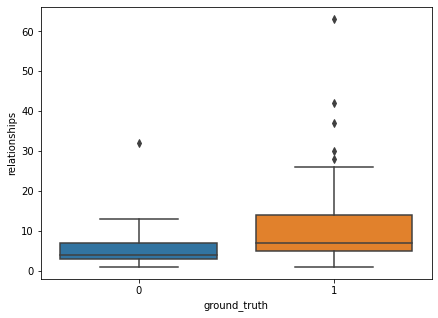

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='relationships', data=df_predictions)

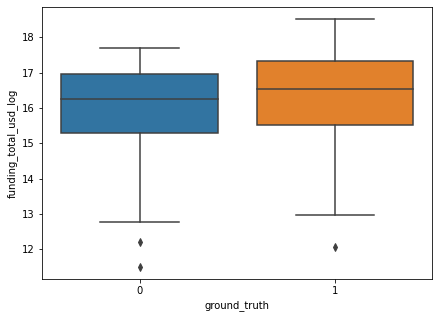

In [25]:
df_predictions['funding_total_usd_log'] = np.log(df_predictions['funding_total_usd'])
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='funding_total_usd_log', data=df_predictions)

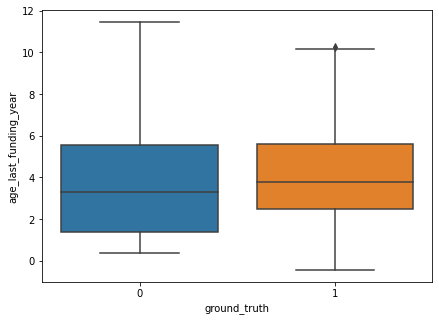

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='age_last_funding_year', data=df_predictions)

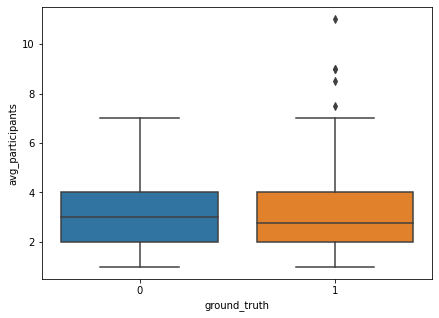

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='avg_participants', data=df_predictions)

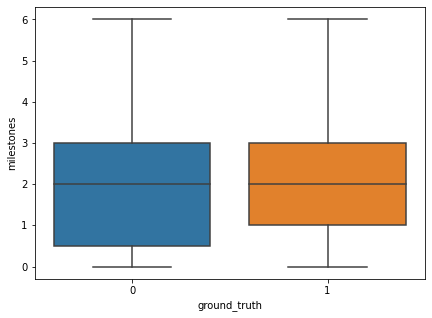

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='milestones', data=df_predictions)

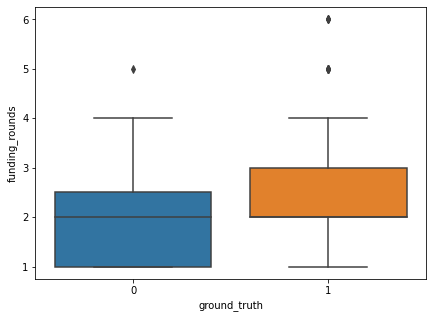

In [29]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='ground_truth', y='funding_rounds', data=df_predictions)

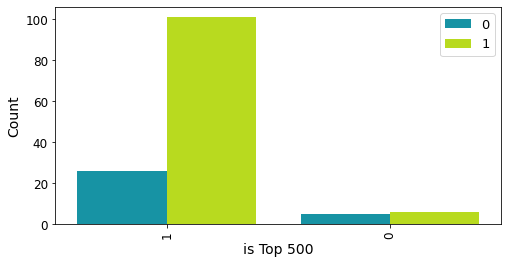

In [30]:
plot_countplot(df=df_predictions, x='is_top500', hue='ground_truth', x_label='is Top 500', y_label='Count',  
                 figsize=(8, 4), sort_by_count=True)

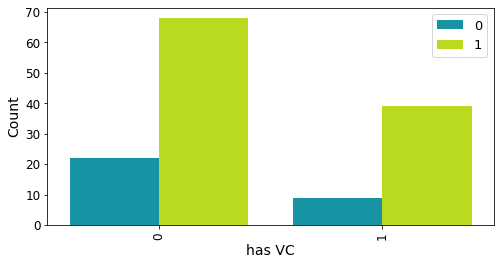

In [31]:
plot_countplot(df=df_predictions, x='has_VC', hue='ground_truth', x_label='has VC', y_label='Count',  
                 figsize=(8, 4), sort_by_count=True)

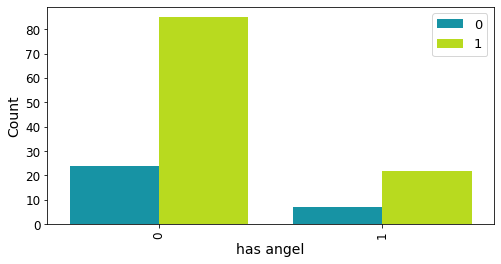

In [32]:
plot_countplot(df=df_predictions, x='has_angel', hue='ground_truth', x_label='has angel', y_label='Count',  
                 figsize=(8, 4), sort_by_count=True)

### Precision/recall tradeoff

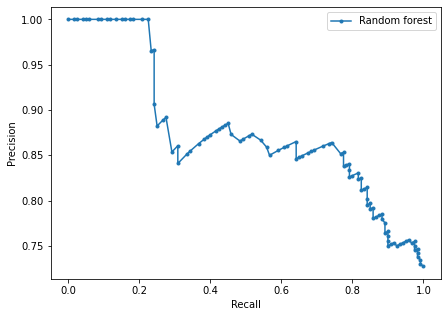

In [33]:
plot_precision_recall_curve(classifier=best_model, 
                            X_test=X_test, 
                            y_test=y_test, 
                            label='Random forest', 
                            figsize=(7, 5))

In [34]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])

In [35]:
threshold_precision = thresholds[np.argmax(precision >= 0.9)]
threshold_precision

0.88

In [36]:
y_pred = (best_model.predict_proba(X_test)[:, 1] >= threshold_precision).astype(int)
evaluate_classifier(y_test, y_pred)

Accuracy: 0.4919
Recall: 0.2417
Precision: 0.9062
F1: 0.3816


In [37]:
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
confusion_matrix

array([[62,  3],
       [91, 29]], dtype=int64)

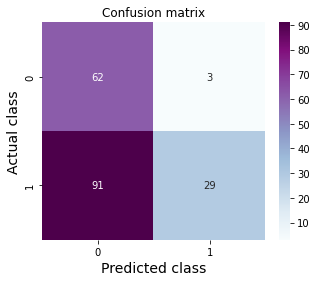

In [38]:
plot_confusion_matrix(confusion_matrix=confusion_matrix, figsize=(5, 4))

In [39]:
y_test_arr = y_test.to_numpy()
false_positives = (y_test_arr != y_pred) & (y_test_arr == 0)
df_false_positives = X_test[false_positives]
print(f'False positives count: {len(df_false_positives)}')
df_false_positives

False positives count: 3


,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
345,1.3781,7,2,1900000,2,0,1,1,0,0,0,2.50,1
36,1.5945,8,2,14600000,3,0,0,1,1,0,0,2.00,1
202,5.5616,8,4,32500000,3,0,0,1,1,1,1,2.75,1
